In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series")

In [36]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
with open('data/pv_imputation.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [6]:
x_features = ['alt', 'azi', 'rad', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres']

x_scaler = MinMaxScaler()
x_scaler.fit(pv[x_features])
pv[x_features] = x_scaler.transform(pv[x_features])

In [7]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,11,30,23,tzinfo=tz)]
pv_val = pv.loc[datetime(2006,11,30,00,tzinfo=tz):datetime(2006,12,20,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,20,00,tzinfo=tz):datetime(2006,12,31,23,tzinfo=tz)]

In [8]:
pv_val_criterion = pv_val.loc[datetime(2006,12,1,00,tzinfo=tz):]
pv_test_criterion = pv_test.loc[datetime(2006,12,21,00,tzinfo=tz):]

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [9]:
from torch.utils.data import DataLoader, Dataset

In [10]:
class windowDataset(Dataset):
    def __init__(self, y, input_window, output_window, num_feature, data_comp, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        # seq_len
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output : shape = (window 크기, sample 개수)
        X = np.zeros([input_window, num_samples, num_feature])
        Y = np.zeros([output_window, num_samples, num_feature])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i,:] = y[start_x:end_x]
            # print(X.shape)

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]
            # print(Y.shape)

        X = X.reshape(X.shape[0], X.shape[1], num_feature).transpose((1,0,2)) # (seq_len, input_window, feature)
        Y = Y.reshape(Y.shape[0], Y.shape[1], num_feature).transpose((1,0,2)) # (seq_len, output_window, 1=power)

        if data_comp==1:
            # Y = Y[:,:,0][:,:,None]
            print(Y.shape)

        if data_comp==2:
            X = Y[:,:,1:].copy()
            Y = Y[:,:,0][:,:,None]
            print(X.shape)
            print(Y.shape)
        
        self.x = X
        self.y = Y
        self.len = len(X)

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return self.len

# model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.auto import tqdm
import random

In [25]:
'''
input shape: 
    input: (batch, seq_len, num_feature) -> LSTM layer 에서 batch_first=True option 사용했을 때 기준
output shape:
    output: (batch, seq_len, hidden_dim)
    hidden_state: (batch, 1, hidden_dim) -> 각 batch 마다 제일 마지막 seq_len 기준
    cell_state: (batch, 1, hidden_dim)
'''

class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

'''
input_shape
    input: (batch, 1, num_feature) -> 직전 timestamp 기준 데이터
    hidden_state: (batch, 1, hidden_dim)
    cell_state: (batch, 1, hidden_dim)
'''

class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(1), encoder_hidden_states)
        output = self.linear(lstm_out)

        return output, self.hidden

class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)
        self.linear = nn.Linear(input_size, 1)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size).to(device)

        # print(f"encoder input: {inputs.shape}")

        _, hidden = self.encoder(inputs)
        # print(f"encoder output: {hidden[0].shape}")

        decoder_input = inputs[:,-1,:] # 각 batch 마다 마지막 time stamp 를 decoder의 input 으로 사용
        # print(f"decoder input: {decoder_input.shape}")

        #원하는 길이가 될 때까지 decoder를 실행한다.
        # print(f"targets shape: {targets.shape}")
        # print(f"outputs shape: {outputs.shape}")
        for t in range(target_len): 
            # print(t)
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            # print(f"out shape: {out.shape}")
            
            # teacher forcing을 구현한다.
            # teacher forcing에 해당하면 다음 인풋값으로는 예측한 값이 아니라 실제 값을 사용한다.
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
                # print(f"decoder input: {decoder_input.shape}")
            else:
                decoder_input = out
                # print(f"decoder input2: {decoder_input.shape}")
            outputs[:,t,:] = out
        outputs = self.linear(outputs)

        # print(f"decoder_output: {outputs.shape}")
        return outputs


# train

In [13]:
iw = 24
ow = 24
num_feature = len(x_features)+1

train_dataset = windowDataset(pv_train[['power_scale']+x_features], 
                              input_window=iw, output_window=ow, num_feature=num_feature, data_comp=2, stride=ow)
valid_dataset = windowDataset(pv_val[['power_scale']+x_features], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=2, stride=ow)
test_dataset = windowDataset(pv_test[['power_scale']+x_features], 
                             input_window=iw, output_window=ow, num_feature=num_feature, data_comp=2, stride=ow)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

(333, 24, 10)
(333, 24, 1)
(20, 24, 10)
(20, 24, 1)
(11, 24, 10)
(11, 24, 1)


In [14]:
a = next(iter(train_loader))
print(a[0].shape)
print(a[1].shape)

torch.Size([64, 24, 10])
torch.Size([64, 24, 1])


In [26]:
def train(model, train_loader, optimizer, criterion, device='cuda'):
    model.train()
    total_loss = 0.0

    for x, y in train_loader:
        optimizer.zero_grad()
        x = x.to(device).float()
        y = y.to(device).float()

        output = model(x, y, ow, 0.0).to(device) # teacher forcing = 0 -> 모두 예측값 사용

        # print(f"x shape: {x.shape}")
        # print(f"y shape: {y.shape}")
        # print(f"pred shape: {output.shape}")
        # print(f"final y shape: {y[:,:,0].shape}")
        # print(f"final pred shape: {output[:,:,0].shape}")

        loss = criterion(output[:,:,0], y[:,:,0])
        loss.backward()
        optimizer.step()
        total_loss += loss.cpu().item()

    train_loss = total_loss/len(train_loader)
    
    return output.detach().cpu().numpy(), y.detach().cpu().numpy(), train_loss

def predict(model, test_loader, criterion, device='cuda', file_name=None):
    model.eval()

    total_loss = 0.0
    outputs = []
    ys = []

    for t, (x, y) in enumerate(test_loader):
        # print(t)
        x = x.to(device).float()
        y = y.to(device).float()

        with torch.no_grad():
            output = model(x, y, ow, 0.0).to(device)
        # print(output.shape)
        # outputs[t,:,:,:] = output
        outputs.append(list(output.detach().cpu().numpy()))
        ys.append(list(y.detach().cpu().numpy()))
        loss = criterion(output[:,:,0], y[:,:,0])
        total_loss += loss.cpu().item()

    test_loss = total_loss/len(test_loader)

    if file_name:
        torch.save(model.state_dict(), file_name)

    return np.array(sum(outputs,[])), np.array(sum(ys,[])), test_loss

# model

In [27]:
# wandb.init(name=str(param), project="TCN_data_composition_1", entity="yyyyyjkim")

In [42]:
param_config = {
    "learning_rate": 0.001,
    "epochs": 1000,
    "input_size": 10,
    "hidden_size": 20
}

In [43]:
device='cuda'
model = lstm_encoder_decoder(input_size=param_config['input_size'], hidden_size=param_config['hidden_size']).to(device)

learning_rate=param_config['learning_rate']
epoch = param_config['epochs']
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [44]:
# 파라미터 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,341 trainable parameters


In [45]:
# wandb.watch(model, log='all', log_freq=10)

val_loss_min = 100
file_name = 'model/basic.model'

pbar = tqdm(range(param_config['epochs']))
for epoch in pbar:
    *result_train, train_loss = train(model, train_loader, optimizer, criterion, device=device)
    *result_val, val_loss = predict(model, val_loader, criterion, device=device)
    *result_test, test_loss = predict(model, test_loader, criterion, device=device)

    if val_loss < val_loss_min:
        val_loss_min = val_loss
        torch.save(model.state_dict(), file_name)
        print(f"epoch: {epoch} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

    # wandb.log({"train_loss": train_loss, "val_loss": val_loss, "test_loss": test_loss, "val_loss_min": val_loss_min})

    pbar.set_postfix(loss=f"train_loss: {train_loss:.5f} / val_loss: {val_loss:.5f} / test_loss: {test_loss:.5f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 0 / val_loss: 0.11510 / test_loss: 0.05181
epoch: 1 / val_loss: 0.09440 / test_loss: 0.04238
epoch: 2 / val_loss: 0.08059 / test_loss: 0.04148
epoch: 3 / val_loss: 0.07638 / test_loss: 0.05163
epoch: 6 / val_loss: 0.07491 / test_loss: 0.05397
epoch: 7 / val_loss: 0.07387 / test_loss: 0.04999
epoch: 8 / val_loss: 0.07350 / test_loss: 0.05022
epoch: 9 / val_loss: 0.07343 / test_loss: 0.05257
epoch: 10 / val_loss: 0.07329 / test_loss: 0.05388
epoch: 11 / val_loss: 0.07304 / test_loss: 0.05478
epoch: 12 / val_loss: 0.07205 / test_loss: 0.05298
epoch: 13 / val_loss: 0.07088 / test_loss: 0.05112
epoch: 14 / val_loss: 0.06951 / test_loss: 0.05070
epoch: 15 / val_loss: 0.06713 / test_loss: 0.05041
epoch: 16 / val_loss: 0.06202 / test_loss: 0.04906
epoch: 17 / val_loss: 0.05002 / test_loss: 0.04437
epoch: 18 / val_loss: 0.02766 / test_loss: 0.04241
epoch: 19 / val_loss: 0.01705 / test_loss: 0.05905
epoch: 20 / val_loss: 0.01246 / test_loss: 0.05295
epoch: 21 / val_loss: 0.01153 / test_lo

In [46]:
# wandb.finish()

# result

In [47]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,:,0].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,:,0].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pv_val_criterion['pred'] = pred_val.reshape(-1)
pv_test_criterion['pred'] = pred_test.reshape(-1)

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

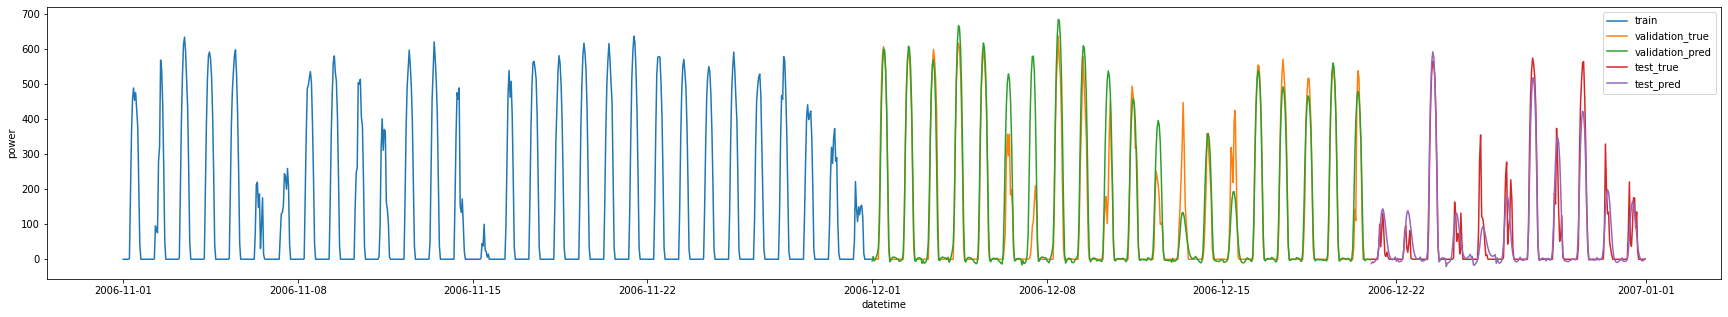

In [48]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['power'], label='validation_true')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['pred'], label='validation_pred')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['power'], label='test_true')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['pred'], label='test_pred')
plt.legend()

In [49]:
print(f"validation MSE: {mean_squared_error(pv_val_criterion['power'], pv_val_criterion['pred']):.5f}")
print(f"validation R2: {r2_score(pv_val_criterion['power'], pv_val_criterion['pred']):.5f}")

print(f"validation MSE: {mean_squared_error(pv_test_criterion['power'], pv_test_criterion['pred']):.5f}")
print(f"validation R2: {r2_score(pv_test_criterion['power'], pv_test_criterion['pred']):.5f}")

validation MSE: 6132.17896
validation R2: 0.82914
validation MSE: 2831.02059
validation R2: 0.85327


In [50]:
model.load_state_dict(torch.load(file_name))
*result_val, val_loss = predict(model, val_loader, criterion, device=device)
*result_test, test_loss = predict(model, test_loader, criterion, device=device)

In [51]:
pred_val = result_val[0]
pred_val = power_scaler.inverse_transform(pred_val[:,:,0].reshape(-1,1))
print(f"pred_val: {len(pred_val)}")

pred_test = result_test[0]
pred_test = power_scaler.inverse_transform(pred_test[:,:,0].reshape(-1,1))
print(f"pred_test: {len(pred_test)}")

pv_val_criterion['pred'] = pred_val.reshape(-1)
pv_test_criterion['pred'] = pred_test.reshape(-1)

pred_val: 480
pred_test: 264


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

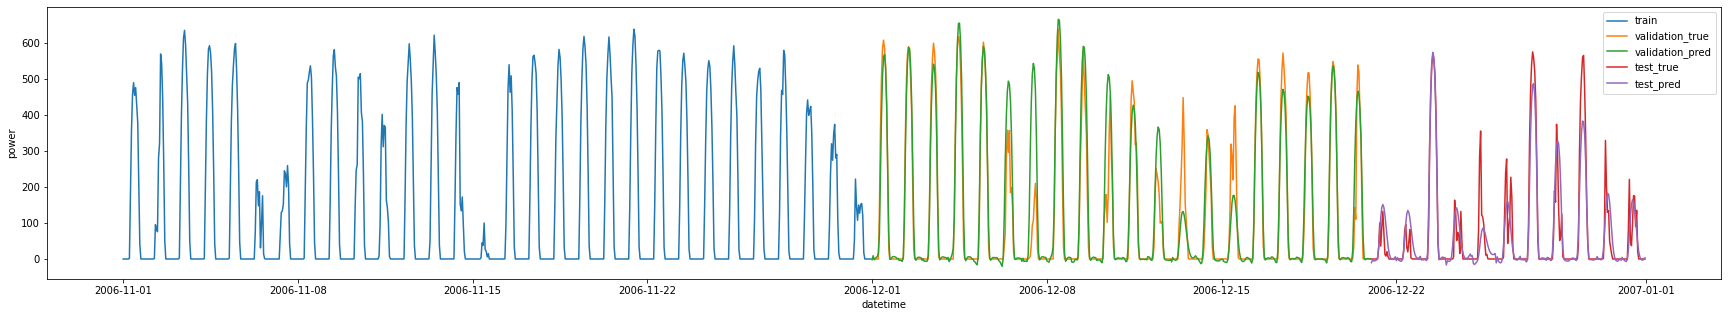

In [52]:
plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,11,1,00,tzinfo=tz):]['power'], label='train')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['power'], label='validation_true')
sns.lineplot(pv_val_criterion.index, pv_val_criterion['pred'], label='validation_pred')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['power'], label='test_true')
sns.lineplot(pv_test_criterion.index, pv_test_criterion['pred'], label='test_pred')
plt.legend()

In [53]:
print(f"validation MSE: {mean_squared_error(pv_val_criterion['power'], pv_val_criterion['pred']):.5f}")
print(f"validation R2: {r2_score(pv_val_criterion['power'], pv_val_criterion['pred']):.5f}")

print(f"validation MSE: {mean_squared_error(pv_test_criterion['power'], pv_test_criterion['pred']):.5f}")
print(f"validation R2: {r2_score(pv_test_criterion['power'], pv_test_criterion['pred']):.5f}")

validation MSE: 5160.25718
validation R2: 0.85622
validation MSE: 3152.15020
validation R2: 0.83663
